# Randomized benchmarking

# main code



## clliford gate selection
random gates selection from the Peter Karalekas senior thesis "Designing quantum algorithms for qubit control calibration"
https://github.com/pkaralekas/senior-thesis/blob/master/docs/thesis-writeup.pdf. 
since the compiler only support $RZ(\theta)$ and $RX(k\pi/2)$ the group is even smaller than the paper suggested.

## for loop
* m: the list of gate lengths for each program 
* trials: for each  program we should run it many times to get statistical results of error
* sequency_trials: for each same randomly generated program's statistical error, we should repeat to have a standard deviation

In [9]:
import numpy as np
from numpy.random import random_integers as rand
from mock import MagicMock
import json

import pyquil
from pyquil.quil import Program
from pyquil.api import QVMConnection, QPUConnection, get_devices, Job,CompilerConnection
from pyquil.gates import *

import math
from random import randint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import linalg
#matplotlib inline

# Set this flag if you want to send programs to Forest.
SEND_PROGRAMS = False

pi = math.pi
m = [1,2,4,8,16,36,60,80,100,128]  # sequence length list
bad_qubits = [2,3,15,18]  
full_list = range(20)   # 20 qubits chip

qubits_list = [i for i in full_list if i not in bad_qubits] # good qubits list

classical_regs_list = [[i] for i in range(20)]
classical_regs = [0]


sequence_trials = 5
fidelity = np.zeros(len(m))
fidelity_noisy = np.zeros((len(full_list),len(m)))
error_bar = np.zeros((len(full_list),len(m)))

trials = 1000


acorn = get_devices(as_dict=True)['19Q-Acorn']
qvm_noisy = QVMConnection(acorn)  # classical acorn model noisy simulation
qvm = QVMConnection()      #classical simulation

if SEND_PROGRAMS:
    qvm = QVMConnection()
    # QPU
    online_devices = [d for d in get_devices() if d.is_online()]
    if online_devices:
        d = online_devices[0]
        qpu = QPUConnection(d.name)
        print("Found online device {}, making QPUConnection".format(d.name))
    else:
        qpu = QVMConnection()
        print("Could not find online device, defaulting to QVM")
else:
    qpu = MagicMock(QPUConnection)
    qpu_job = MagicMock(Job)
    qpu.wait_for_job.return_value = qpu_job
    qpu_job.result.side_effect = json.load(open("qpu.json", 'r'))

In [10]:
# the function use the random choice of n (1-4) to return/select random RX,RZ gate
def random_compiler_clifford(n,qubit): 
    list = {
        0:
            RX(pi/2)(qubit),
        1:
            RX(-pi/2)(qubit),
        2:
            RZ(pi/2)(qubit),   
        3:
            RZ(-pi/2)(qubit)
    }
    
    return list[n]

def random_compiler_clifford_inverse(n,qubit): 
    list = {
        0:
            RX(-pi/2)(qubit),
        1:
            RX(pi/2)(qubit),
        2:
            RZ(-pi/2)(qubit),   
        3:
            RZ(pi/2)(qubit)
    }
    
    return list[n]


for qubit in qubits_list:
    for index,j in enumerate(m):
        error = np.zeros(sequence_trials)
        for k in range(0,sequence_trials): # no of random sequence of same length

            #program, x series  initialization
            program = Program()
            x_series = np.zeros(j)
            
            program.inst("PRAGMA PRESERVE_BLOCK")
            #inside the preserve region, the complier will not touch it
            for i in range(0,j):
                x = randint(0, 3)
                x_series[i] = x
                program.inst(random_compiler_clifford(x,qubit))
            
            # apply m operations and then apply m inverse operations
            for i in range(0,j):
                x = x_series[j-1-i]
                program.inst(random_compiler_clifford_inverse(x,qubit))
            program.measure(qubit,classical_regs)
            #inside the preserve region, the complier will not touch it
            program.inst("PRAGMA END_PRESERVE_BLOCK")        

            error[k] = np.sum(qvm_noisy.run(program,classical_regs,trials,needs_compilation=False))/trials

        fidelity_noisy[qubit,index] = 1- sum(error) / float(len(error))
        error_bar[qubit,index] = np.std(error) 

    
    print ("fidelity data", qubit)
    print(fidelity_noisy[qubit])
    print ("error bar data", qubit)
    print (error_bar[qubit])
    print ("----------------------------")


fidelity data 0
[ 0.9334  0.9338  0.9256  0.9134  0.8592  0.7966  0.7256  0.6636  0.6338
  0.6188]
error bar data 0
[ 0.00972831  0.01094349  0.01228983  0.0169068   0.01441388  0.02356777
  0.02010572  0.02182292  0.01202331  0.01726731]
----------------------------
fidelity data 1
[ 0.95    0.9426  0.9398  0.9256  0.874   0.8116  0.7642  0.7022  0.669
  0.6218]
error bar data 1
[ 0.00419524  0.00891291  0.00901998  0.02890398  0.01465606  0.02838732
  0.004996    0.01920833  0.0160125   0.00968297]
----------------------------
fidelity data 4
[ 0.948   0.9432  0.9222  0.9122  0.8492  0.7766  0.7052  0.63    0.6164
  0.5576]
error bar data 4
[ 0.00532917  0.01230285  0.010008    0.00798499  0.01423236  0.03267782
  0.02253353  0.01646815  0.01455472  0.02699333]
----------------------------
fidelity data 5
[ 0.9632  0.9536  0.955   0.9478  0.9262  0.8538  0.8034  0.7606  0.716
  0.6706]
error bar data 5
[ 0.00515364  0.00852291  0.00609918  0.0082801   0.00886341  0.01731358
  0.02277

In [11]:
print(fidelity_noisy)

[[ 0.9334  0.9338  0.9256  0.9134  0.8592  0.7966  0.7256  0.6636  0.6338
   0.6188]
 [ 0.95    0.9426  0.9398  0.9256  0.874   0.8116  0.7642  0.7022  0.669
   0.6218]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.948   0.9432  0.9222  0.9122  0.8492  0.7766  0.7052  0.63    0.6164
   0.5576]
 [ 0.9632  0.9536  0.955   0.9478  0.9262  0.8538  0.8034  0.7606  0.716
   0.6706]
 [ 0.8308  0.837   0.8418  0.8218  0.8298  0.788   0.7766  0.7494  0.724
   0.7194]
 [ 0.924   0.9236  0.9116  0.9014  0.8888  0.8462  0.788   0.7554  0.7388
   0.6844]
 [ 0.9426  0.9494  0.9368  0.922   0.9008  0.8666  0.8134  0.7666  0.7534
   0.7002]
 [ 0.9248  0.919   0.9094  0.91    0.8808  0.8152  0.7788  0.732   0.7064
   0.6756]
 [ 0.9412  0.9396  0.9378  0.919   0.8926  0.8252  0.7718  0.7388  0.6912
   0.6218]
 [ 0.894   0.8878  0.8794  0.856   0.8206  0.7168  0.6628  0.6162  0.574

# fitting model 
from paper "Scalable and Robust Randomized Benchmarking of Quantum Processes" (E Magesan,et al 2011)
https://arxiv.org/pdf/1009.3639.pdf

\begin{equation*}
F_{seq} = Ap^m+B
\end{equation*}

where A,B,p are fitting parameters and p is the decay rate and A.B absorbs state preparation and measurement errors as well as the error on the final gate. the total gate operation is 2m in each program but the computational basis operation is still m.

the single qubit gate fidelity d = 2.

\begin{equation*}
 r = 1 - p - (1-p)/ d.    
\end{equation*}

\begin{equation*}
 F = p +(1−p)/ 2  
\end{equation*}



[ 0.4104181   0.98668866  0.53515761]
average decay rate p =  0.986688662414


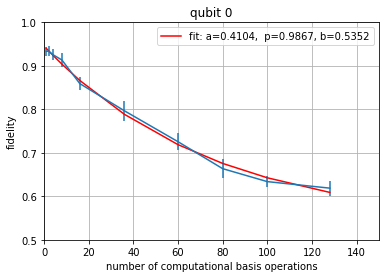

[ 0.45357419  0.99010213  0.5       ]
average decay rate p =  0.990102131155


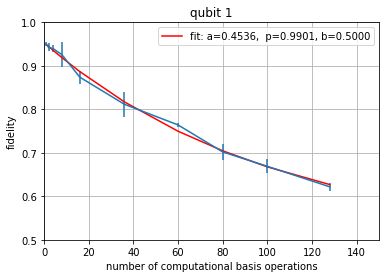

[ 0.4540934   0.98566538  0.5       ]
average decay rate p =  0.985665379994


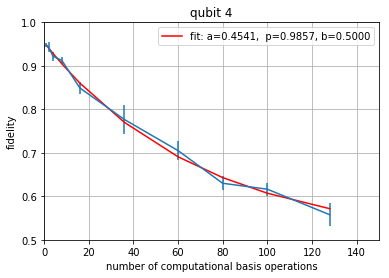

[ 0.47007187  0.99241515  0.5       ]
average decay rate p =  0.992415149096


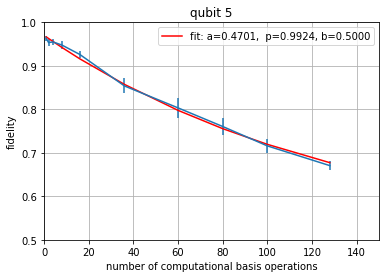

[ 0.23724154  0.99410475  0.60258826]
average decay rate p =  0.99410474642


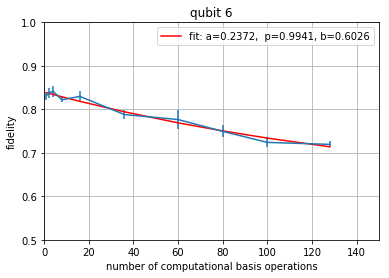

[ 0.42628499  0.99376315  0.5       ]
average decay rate p =  0.993763153954


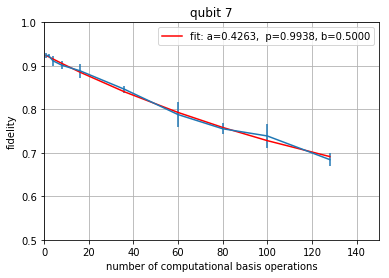

[ 0.44777722  0.99393366  0.5       ]
average decay rate p =  0.993933657325


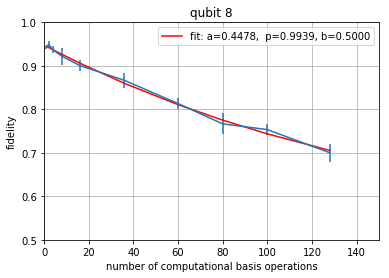

[ 0.35786096  0.99041388  0.57038883]
average decay rate p =  0.990413876275


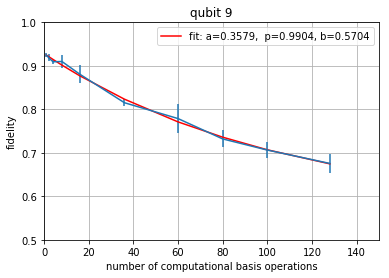

[ 0.45019551  0.99123562  0.5       ]
average decay rate p =  0.991235619182


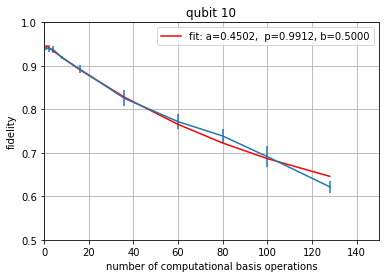

[ 0.40186883  0.9842261   0.50091743]
average decay rate p =  0.98422610334


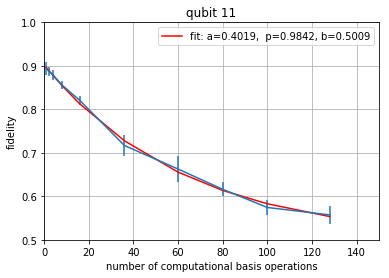

[ 0.44782013  0.98936045  0.5       ]
average decay rate p =  0.989360446037


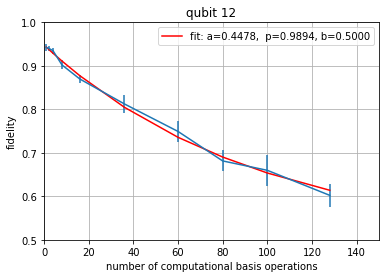

[ 0.42940318  0.99284713  0.5       ]
average decay rate p =  0.992847129944


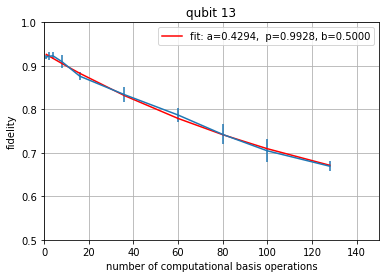

[ 0.39058223  0.98816703  0.56399965]
average decay rate p =  0.988167032731


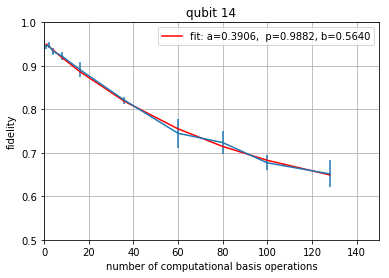

[ 0.4505316   0.98945681  0.5       ]
average decay rate p =  0.989456807799


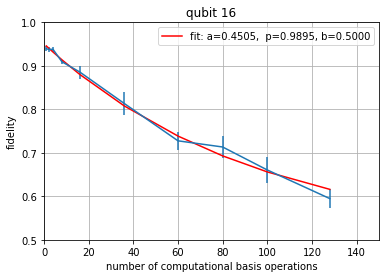

[ 0.39196658  0.98816176  0.53654713]
average decay rate p =  0.988161761051


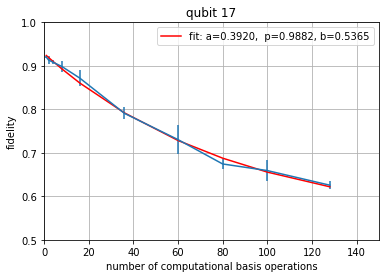

[ 0.435038    0.99201188  0.5       ]
average decay rate p =  0.992011884498


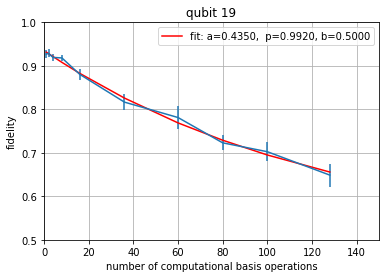

In [15]:
def gate_independence_fit(x,a,p,b):
    return a*p**x+b
    # a,b,p fitting parameters, p is the decay rate and a,b will absorbs initialization / measurement errors

decay_rate = np.zeros(len(full_list))

xdata = m
for i in qubits_list:

    ydata = fidelity_noisy[i]
    error = error_bar[i]
    popt,pcov = curve_fit(gate_independence_fit,xdata,ydata,bounds = ([0,0.8,0.5],1))
    print(popt)
    decay_rate[i] = popt[1]
    print("average decay rate p = ",  decay_rate[i])

    
    plt.errorbar(xdata, ydata, yerr=error)
    plt.plot(xdata,gate_independence_fit(xdata,*popt),'r-',label = 'fit: a=%5.4f,  p=%5.4f, b=%5.4f' %tuple(popt))
    plt.grid()
    plt.yscale('linear')
    plt.axis([0, 150, 0.5, 1.0])
    plt.ylabel("fidelity")
    plt.xlabel("number of computational basis operations")
    plt.title("qubit " + str(i))
    plt.legend()
    plt.savefig("second fidelity_plot qubit" + str(i))
    plt.show()



In [16]:
print(decay_rate)

[ 0.98668866  0.99010213  0.          0.          0.98566538  0.99241515
  0.99410475  0.99376315  0.99393366  0.99041388  0.99123562  0.9842261
  0.98936045  0.99284713  0.98816703  0.          0.98945681  0.98816176
  0.          0.99201188]


In [18]:
fidelity = np.zeros(len(full_list))
fidelity = decay_rate+ (1-decay_rate)/2
print(fidelity)
# ignore bad qubits show 0.5 fidelity below

[ 0.99334433  0.99505107  0.5         0.5         0.99283269  0.99620757
  0.99705237  0.99688158  0.99696683  0.99520694  0.99561781  0.99211305
  0.99468022  0.99642356  0.99408352  0.5         0.9947284   0.99408088
  0.5         0.99600594]
